In [1]:
import mne
import numpy as np
from scipy.signal import welch
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.feature_selection import RFE
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [2]:
# Definição do info (MNE)
n_channels = 8
ch_types = ['eeg'] * n_channels
sfreq = 250
ch_names = ["F3", "Fz", "F4", "C3", "Cz", "C4", "P3", "P4"]
info = mne.create_info(ch_names=ch_names, sfreq=sfreq, ch_types=ch_types)
info.set_montage("standard_1020")


<Info | 8 non-empty values
 bads: []
 ch_names: F3, Fz, F4, C3, Cz, C4, P3, P4
 chs: 8 EEG
 custom_ref_applied: False
 dig: 11 items (3 Cardinal, 8 EEG)
 highpass: 0.0 Hz
 lowpass: 125.0 Hz
 meas_date: unspecified
 nchan: 8
 projs: []
 sfreq: 250.0 Hz
>

In [3]:
# Carregando os dados do Teste Final
arquivos_teste = ['../dataset/s5/tF/OpenBCI-RAW-2023-11-06_19-56-20.txt']
dados_teste = [np.loadtxt(arquivo, delimiter=',', skiprows=5, usecols=range(1, 9)) for arquivo in arquivos_teste]

# Carregando os dados do Basal
arquivos_basal = ['../dataset/s5/tF/OpenBCI-RAW-2023-11-06_19-56-20.txt']
dados_basal_brutos = [np.loadtxt(arquivo, delimiter=',', skiprows=5, usecols=range(1, 9)) for arquivo in arquivos_basal]

# Definindo a faixa do basal
inicio_basal = 250 * (1 * 60 + 41)  # Início em 1:41
fim_basal = 250 * (2 * 60 + 49)     # Fim em 2:49
dados_basal = dados_basal_brutos[0][inicio_basal:fim_basal, :]  # Extrai dados de 1:41 até 2:49

# Ignorando os primeiros 2 minutos para remover ruído inicial
inicio_teste = sfreq * 120          
fim_teste = inicio_teste + sfreq * 60 * 10
dados_amostra = dados_teste[0][inicio_teste:fim_teste, :]  # Extrai 10 minutos de amostra

# Processamento das amostras com MNE e filtros
dados_amostra_mne = mne.io.RawArray(dados_amostra.T, info)
dados_amostra_mne.notch_filter(freqs=60)  # Filtro notch de 60 Hz
dados_amostra_mne.filter(l_freq=4, h_freq=100)  # Filtro passa-banda de 4 a 100 Hz
freqs, dados_amostra_freq = welch(dados_amostra_mne.get_data(), fs=250, nperseg=1024, noverlap=512)

# Normalizando as frequências
normalizador = StandardScaler()
dados_amostra_freq_normalizado = normalizador.fit_transform(dados_amostra_freq)

# Processamento dos dados basais
dados_basal_mne = mne.io.RawArray(dados_basal.T, info)
dados_basal_mne.notch_filter(freqs=60)  # Filtro notch de 60 Hz
dados_basal_mne.filter(l_freq=4, h_freq=100)  # Filtro passa-banda de 4 a 100 Hz
freqs_basal, dados_basal_freq = welch(dados_basal_mne.get_data(), fs=250, nperseg=1024, noverlap=512)

# Normalizando os dados basais
normalizador_basal = StandardScaler()
dados_basal_freq_normalizado = normalizador_basal.fit_transform(dados_basal_freq)

Creating RawArray with float64 data, n_channels=8, n_times=150000
    Range : 0 ... 149999 =      0.000 ...   599.996 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge: 60.65 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 60.90 Hz)
- Filter length: 1651 samples (6.604 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband 

In [4]:
# Parâmetros de amostragem
tamanho_amostra = 10 * 60
tamanho_amostra_pontos = tamanho_amostra * sfreq
tamanho_buffer = 5
tamanho_buffer_pontos = tamanho_buffer * sfreq
passo = 1 * 250
overlap = 4 * 250

# Definir os limites das bandas de frequência (em Hz)
theta_band = (4, 8)       # Theta: 4 - 8 Hz
alpha_band = (8, 13)      # Alpha: 8 - 13 Hz
beta_band = (13, 30)      # Beta: 13 - 30 Hz
gamma_band = (30, 100)    # Gamma: 30 - 100 Hz

# Criando amostras de 5 segundos
amostras_alvo = []
amostras_descarte = []
amostras_theta = []


[51, 0, 0, 549]


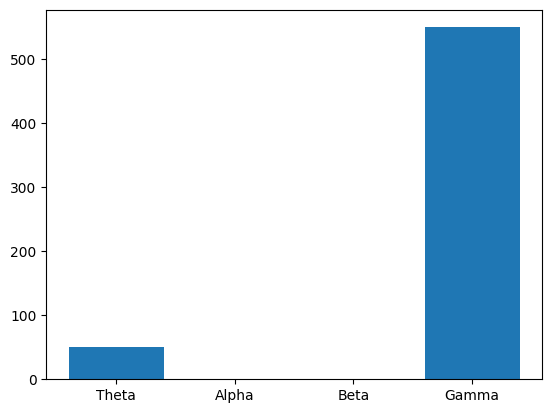

Amostra alvo: 549
Amostra descarte: 51


In [5]:
jump = 5  # 5 segundos de buffer
size = sfreq * jump  # quantidade de pontos avaliados

sample = {'f': [], 'nf': []}
total_pc = {}
results = [0, 0, 0, 0]

# Processando as amostras
for i in range(0, dados_amostra_mne.n_times, passo):
    if i + size < dados_amostra_mne.n_times:
        cut = dados_amostra_mne.copy().crop(tmin=dados_amostra_mne.times[i], tmax=dados_amostra_mne.times[i] + jump)
    else:
        cut = dados_amostra_mne.copy().crop(tmin=dados_amostra_mne.times[i], tmax=dados_amostra_mne.times[-1])  
    
    freqs, psd = welch(cut.get_data(), fs=sfreq, nperseg=128, noverlap=64)
    psd_media = np.average(psd, axis=0)

    # Índices das frequências de interesse
    theta_idxs = np.where((freqs >= theta_band[0]) & (freqs <= theta_band[1]))[0]
    alpha_idxs = np.where((freqs >= alpha_band[0]) & (freqs <= alpha_band[1]))[0]
    beta_idxs = np.where((freqs >= beta_band[0]) & (freqs <= beta_band[1]))[0]
    gamma_idxs = np.where((freqs >= gamma_band[0]) & (freqs <= gamma_band[1]))[0]

    # Potência em cada banda de frequência
    bands = [np.sum(psd_media[theta_idxs]), np.sum(psd_media[alpha_idxs]), np.sum(psd_media[beta_idxs]), np.sum(psd_media[gamma_idxs])]
    results[np.argmax(bands)] += 1

    # Classificação das amostras
    if np.argmax(bands) in [2, 3]:
        sample['f'].append(psd_media)
    else:
        sample['nf'].append(psd_media)

# Resultados
print(results)
plt.bar(['Theta', 'Alpha', 'Beta', 'Gamma'], results)
plt.show()

print("Amostra alvo: " + str(len(sample['f'])))
print("Amostra descarte: " + str(len(sample['nf'])))

In [6]:
# Estimando o ruído de fundo (basal)
base_power = np.average(dados_basal_freq_normalizado)
estimated_background_noise = base_power
print(estimated_background_noise)


8.656709743665937e-17


In [7]:
# Ajustando as amplitudes
data_focus = sample['f'] + sample['nf']
target_amplitudes_adjusted = data_focus - estimated_background_noise

# Narrow Band SNR
narrow_band_SNR = 10 * np.log10(target_amplitudes_adjusted / estimated_background_noise)
print("\nNarrow Band SNR")
print(narrow_band_SNR)

# Wide Band SNR
total_power = np.sum(target_amplitudes_adjusted)
wide_band_SNR = 10 * np.log10(target_amplitudes_adjusted / total_power)
print("\nWide Band SNR")
print(wide_band_SNR)



Narrow Band SNR
[[161.37935288 166.83142256 172.47086659 ... 138.02670823 123.89144901
  112.42718167]
 [158.12922495 165.41610593 171.94798529 ... 138.5627452  124.65239515
  114.03197534]
 [156.80052083 166.07598802 170.63755877 ... 138.9499666  124.49273042
  114.21234812]
 ...
 [168.29520867 178.47349697 182.13549519 ... 137.39675853 125.35855742
  112.42862365]
 [167.10245775 178.95247314 182.82771162 ... 137.03896752 125.30178647
  112.00373573]
 [167.56348652 178.97162106 182.6021274  ... 136.12451173 124.78478577
  112.77203874]]

Wide Band SNR
[[ -52.60434262  -47.15227294  -41.51282891 ...  -75.95698727
   -90.09224648 -101.55651382]
 [ -55.85447055  -48.56758957  -42.03571021 ...  -75.4209503
   -89.33130035  -99.95172016]
 [ -57.18317467  -47.90770748  -43.34613673 ...  -75.0337289
   -89.49096507  -99.77134738]
 ...
 [ -45.68848682  -35.51019852  -31.84820031 ...  -76.58693697
   -88.62513808 -101.55507185]
 [ -46.88123774  -35.03122235  -31.15598388 ...  -76.94472798
   


Sem RFE

Acurácia: 0.9666666666666667
Relatório de classificação:
              precision    recall  f1-score   support

           0       0.93      0.74      0.82        19
           1       0.97      0.99      0.98       161

    accuracy                           0.97       180
   macro avg       0.95      0.87      0.90       180
weighted avg       0.97      0.97      0.96       180


Com RFE

Acurácia: 0.9611111111111111
Relatório de classificação:
              precision    recall  f1-score   support

           0       0.88      0.74      0.80        19
           1       0.97      0.99      0.98       161

    accuracy                           0.96       180
   macro avg       0.92      0.86      0.89       180
weighted avg       0.96      0.96      0.96       180



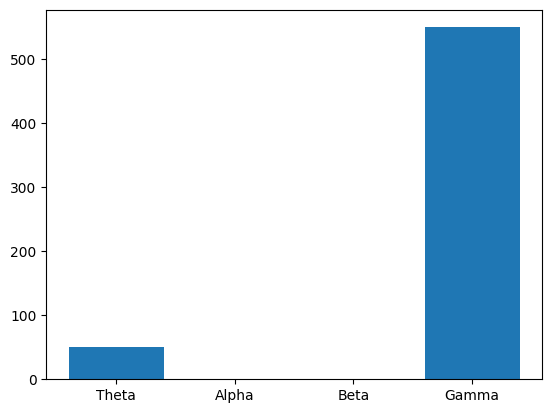

In [8]:
# Preparando os dados de amostra para treino e teste
caracteristicas = sample['f'] + sample['nf']
rotulos = [1] * len(sample['f']) + [0] * len(sample['nf'])  # 1 para "foco", 0 para "não foco"

# Separação dos dados: 70% treino, 30% teste
X_treino, X_teste, y_treino, y_teste = train_test_split(caracteristicas, rotulos, test_size=0.3, random_state=42)

# Normalização
normalizador = StandardScaler()
X_treino_normalizado = normalizador.fit_transform(X_treino)
X_teste_normalizado = normalizador.transform(X_teste)

# SVM sem RFE
modelo_svm = SVC(kernel='linear')
modelo_svm.fit(X_treino_normalizado, y_treino)
y_pred_sem_rfe = modelo_svm.predict(X_teste_normalizado)

# SVM com RFE
seletor = RFE(modelo_svm, n_features_to_select=32, step=1)
seletor.fit(X_treino_normalizado, y_treino)
y_pred_com_rfe = seletor.predict(X_teste_normalizado)

# Resultados
print("\nSem RFE\n")
print(f"Acurácia: {accuracy_score(y_teste, y_pred_sem_rfe)}")
print(f"Relatório de classificação:\n{classification_report(y_teste, y_pred_sem_rfe)}")

print("\nCom RFE\n")
print(f"Acurácia: {accuracy_score(y_teste, y_pred_com_rfe)}")
print(f"Relatório de classificação:\n{classification_report(y_teste, y_pred_com_rfe)}")

# Plotando os resultados
plt.bar(['Theta', 'Alpha', 'Beta', 'Gamma'], results)
plt.show()
